In [6]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import h5py
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize 
import yt
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

We can run a few simulations in Gmunu. Looking at the .dat files (output from the simulations) is a bit trickier. Hence, we load them here and postprocess/discuss/plot the data in this Python notebook.

# Smooth sine wave

Define the analytic results

In [26]:
A = 0.2
v0 = 0.2
theta = 0.0

def rho_sol_pt(x,y,t):
    return 1.0 + A * np.sin(2.0 * np.pi * ( ( x * np.cos(theta) + y * np.sin(theta) ) - ( v0 * np.cos(theta) ) * t ) )

rho_sol = np.vectorize(rho_sol_pt)

def gamma(field, data):
    return  np.sqrt( 1.0 + (data['W_vel1']**2) )
def veloc1(field, data):
    return data['W_vel1'] / data['gamma']

Read in the Kastaun and neural net sine waves

In [27]:
fname = os.path.join(master_dir, "Data/kastaun_output0020.dat")
kastaun_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/neuralnet_output0020.dat")
neuralnet_wave = yt.load(fname)

yt : [INFO     ] 2023-04-07 13:51:20,949 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-04-07 13:51:20,951 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-04-07 13:51:20,952 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-07 13:51:20,954 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-04-07 13:51:20,955 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-04-07 13:51:21,104 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-04-07 13:51:21,105 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-04-07 13:51:21,108 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-07 13:51:21,109 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-04-07 13:51:21,111 Parameters: cosmological_simulation   = 0


In [37]:
# Final time of simulation 
T_final = float(kastaun_wave.current_time)
# Additional preprocessing - see Gmunu for the source of this
for wave in [kastaun_wave, neuralnet_wave]:
    # Add gamma and veloc1
    wave.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    wave.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
# Get the plotdata
plotdata_kastaun   = kastaun_wave.ortho_ray(0, (0, 0))
plotdata_neuralnet = neuralnet_wave.ortho_ray(0, (0, 0))

yt : [WARNING  ] 2023-04-07 13:58:34,967 Field ('amrvac', 'gamma') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2023-04-07 13:58:34,970 Field ('amrvac', 'veloc1') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2023-04-07 13:58:34,975 Field ('amrvac', 'gamma') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2023-04-07 13:58:34,977 Field ('amrvac', 'veloc1') already exists. To override use `force_override=True`.


## Both waves

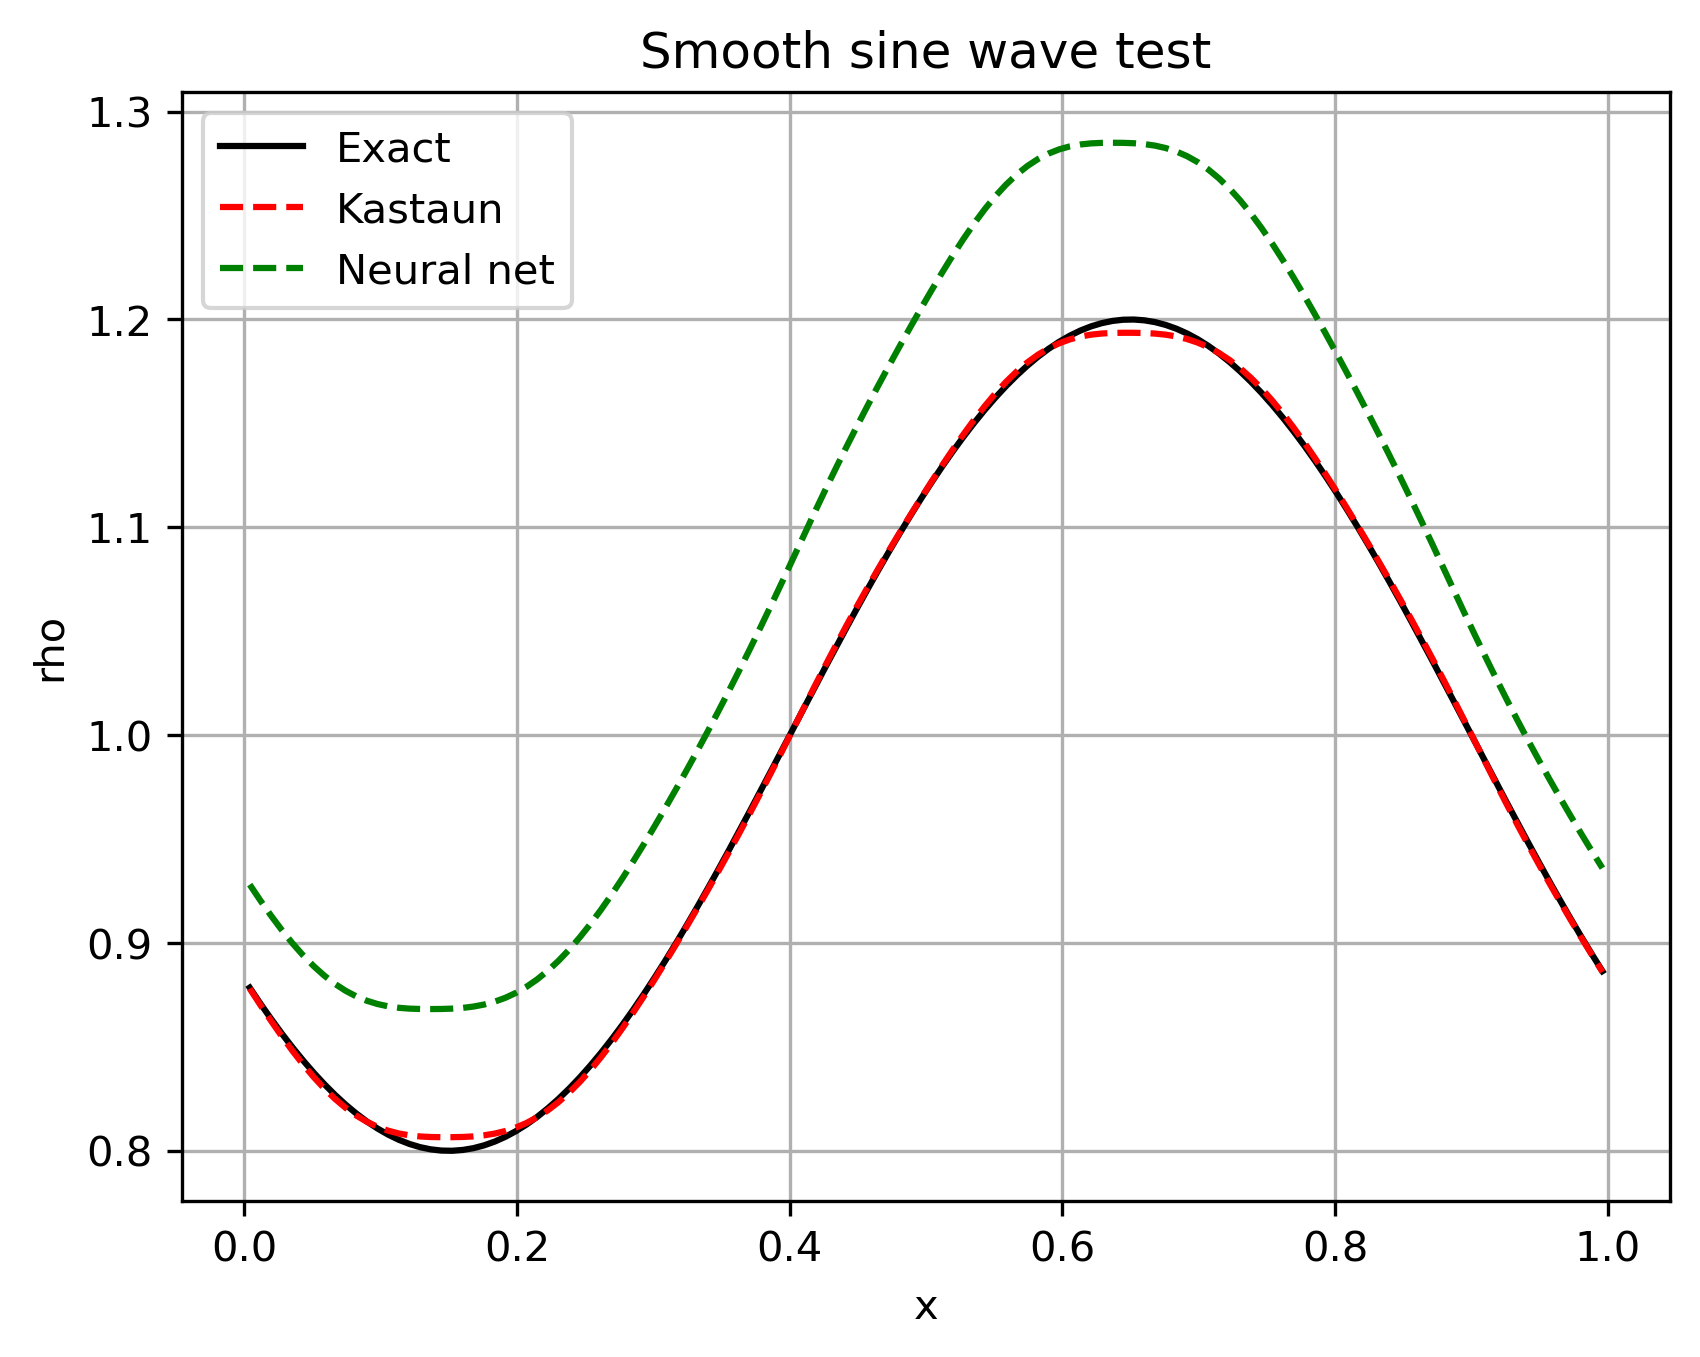

In [46]:
waves = [kastaun_wave, neuralnet_wave]
labels = ["Kastaun", "Neural net"]
plotstyles = ["r--", "g--"]

for i, wave in enumerate(waves):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        plt.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact")
    # The approximation
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), plotstyles[i], ms = 2, label=labels[i])

plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("rho")
plt.title("Smooth sine wave test")
plt.savefig("smooth_wave_rho_kastaun_neuralnet.pdf", bbox_inches='tight')
plt.show()

In [45]:
plotdata.__dict__.keys()

dict_keys(['comm', '_grids', '_distributed', 'ds', '_current_particle_type', '_current_fluid_type', 'field_data', '_default_field_parameters', 'field_parameters', '_data_source', 'quantities', '_sortkey', '_sorted', 'axis', 'px_ax', 'py_ax', 'px_dx', 'py_dx', 'px', 'py', 'sort_by', '_index', '_selector', '_chunk_info', 'size', 'shape', '_current_chunk', '_locked'])

__TODO__ how to get other entries in the .dat file?

YTFieldNotFound: Could not find field ('unknown', 'px') in kastaun_output0020.dat.

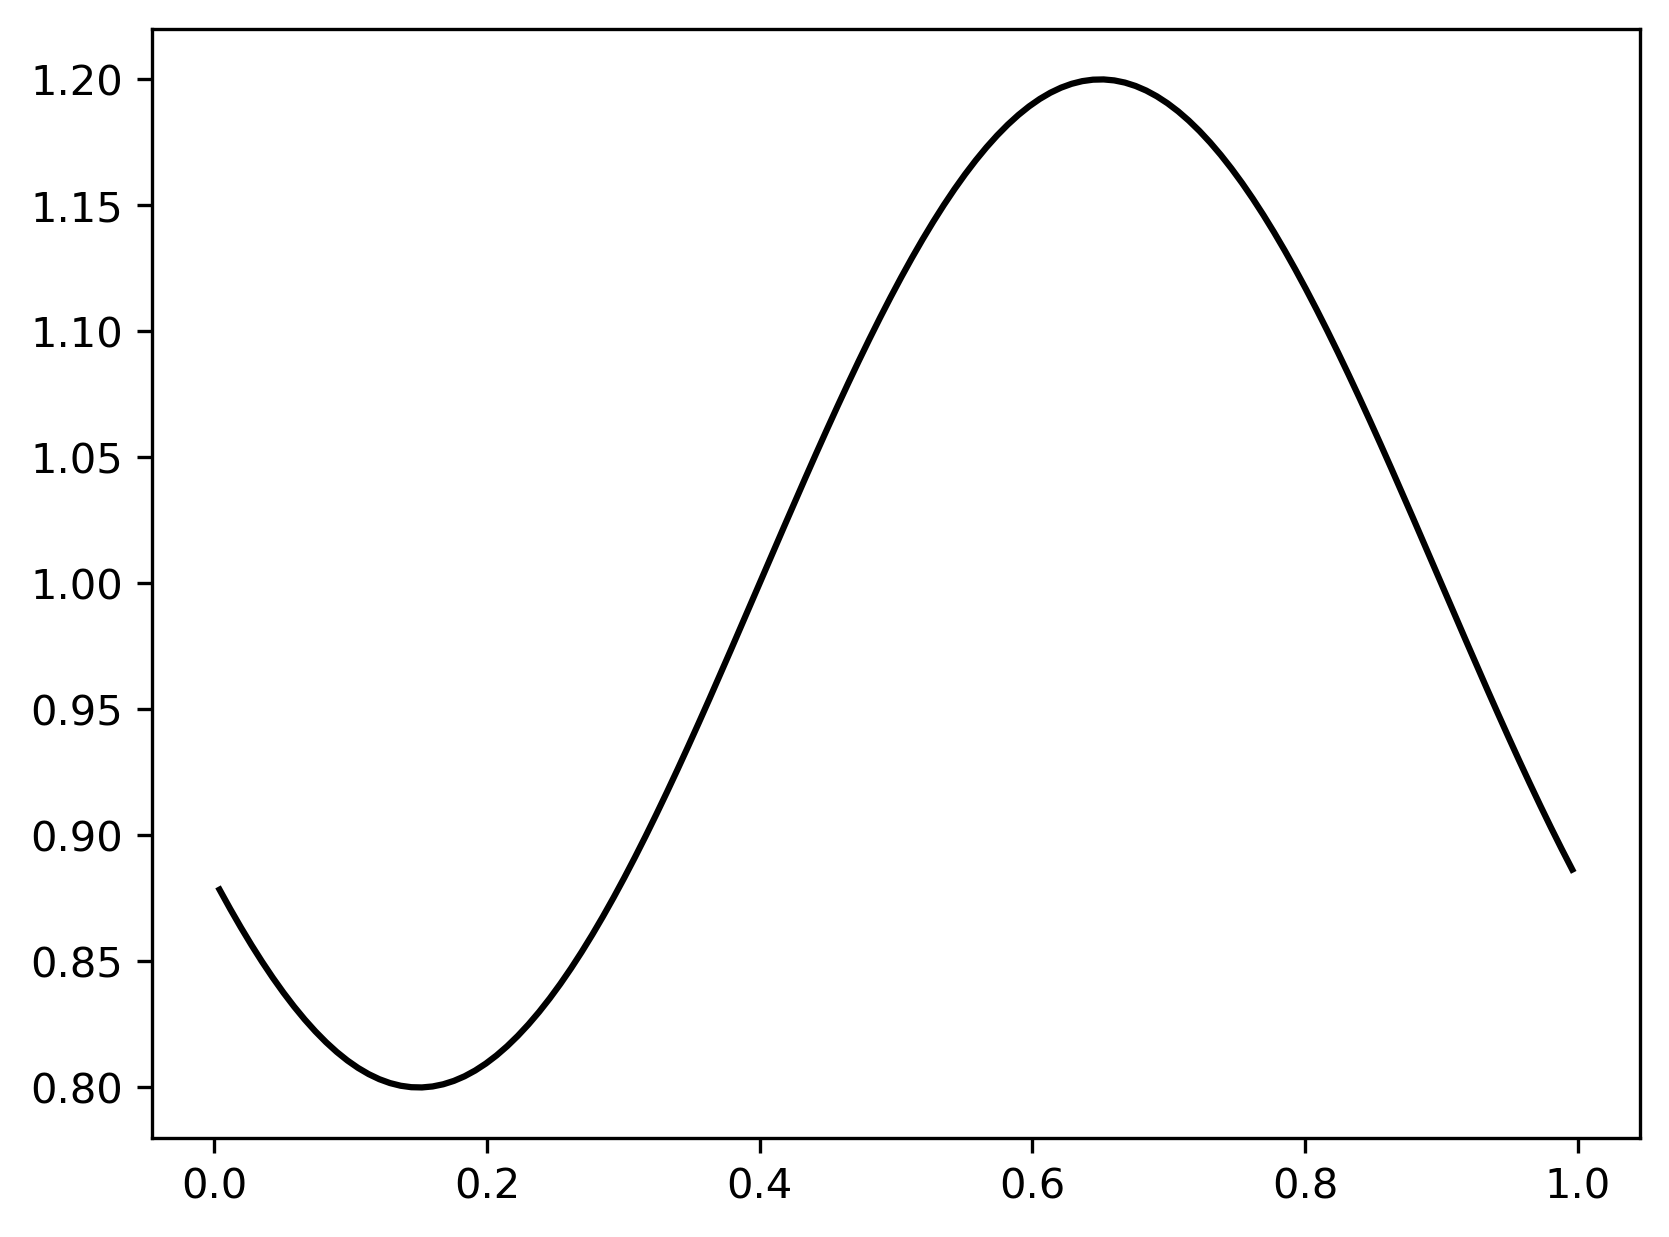

In [47]:
waves = [kastaun_wave, neuralnet_wave]
labels = ["Kastaun", "Neural net"]
plotstyles = ["r--", "g--"]

for i, wave in enumerate(waves):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        plt.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact")
    # The approximation
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['px'][srt]), plotstyles[i], ms = 2, label=labels[i])

plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("rho")
plt.title("Smooth sine wave test")
plt.savefig("smooth_wave_p_kastaun_neuralnet.pdf", bbox_inches='tight')
plt.show()

Difference between kastaun and neuralnet?

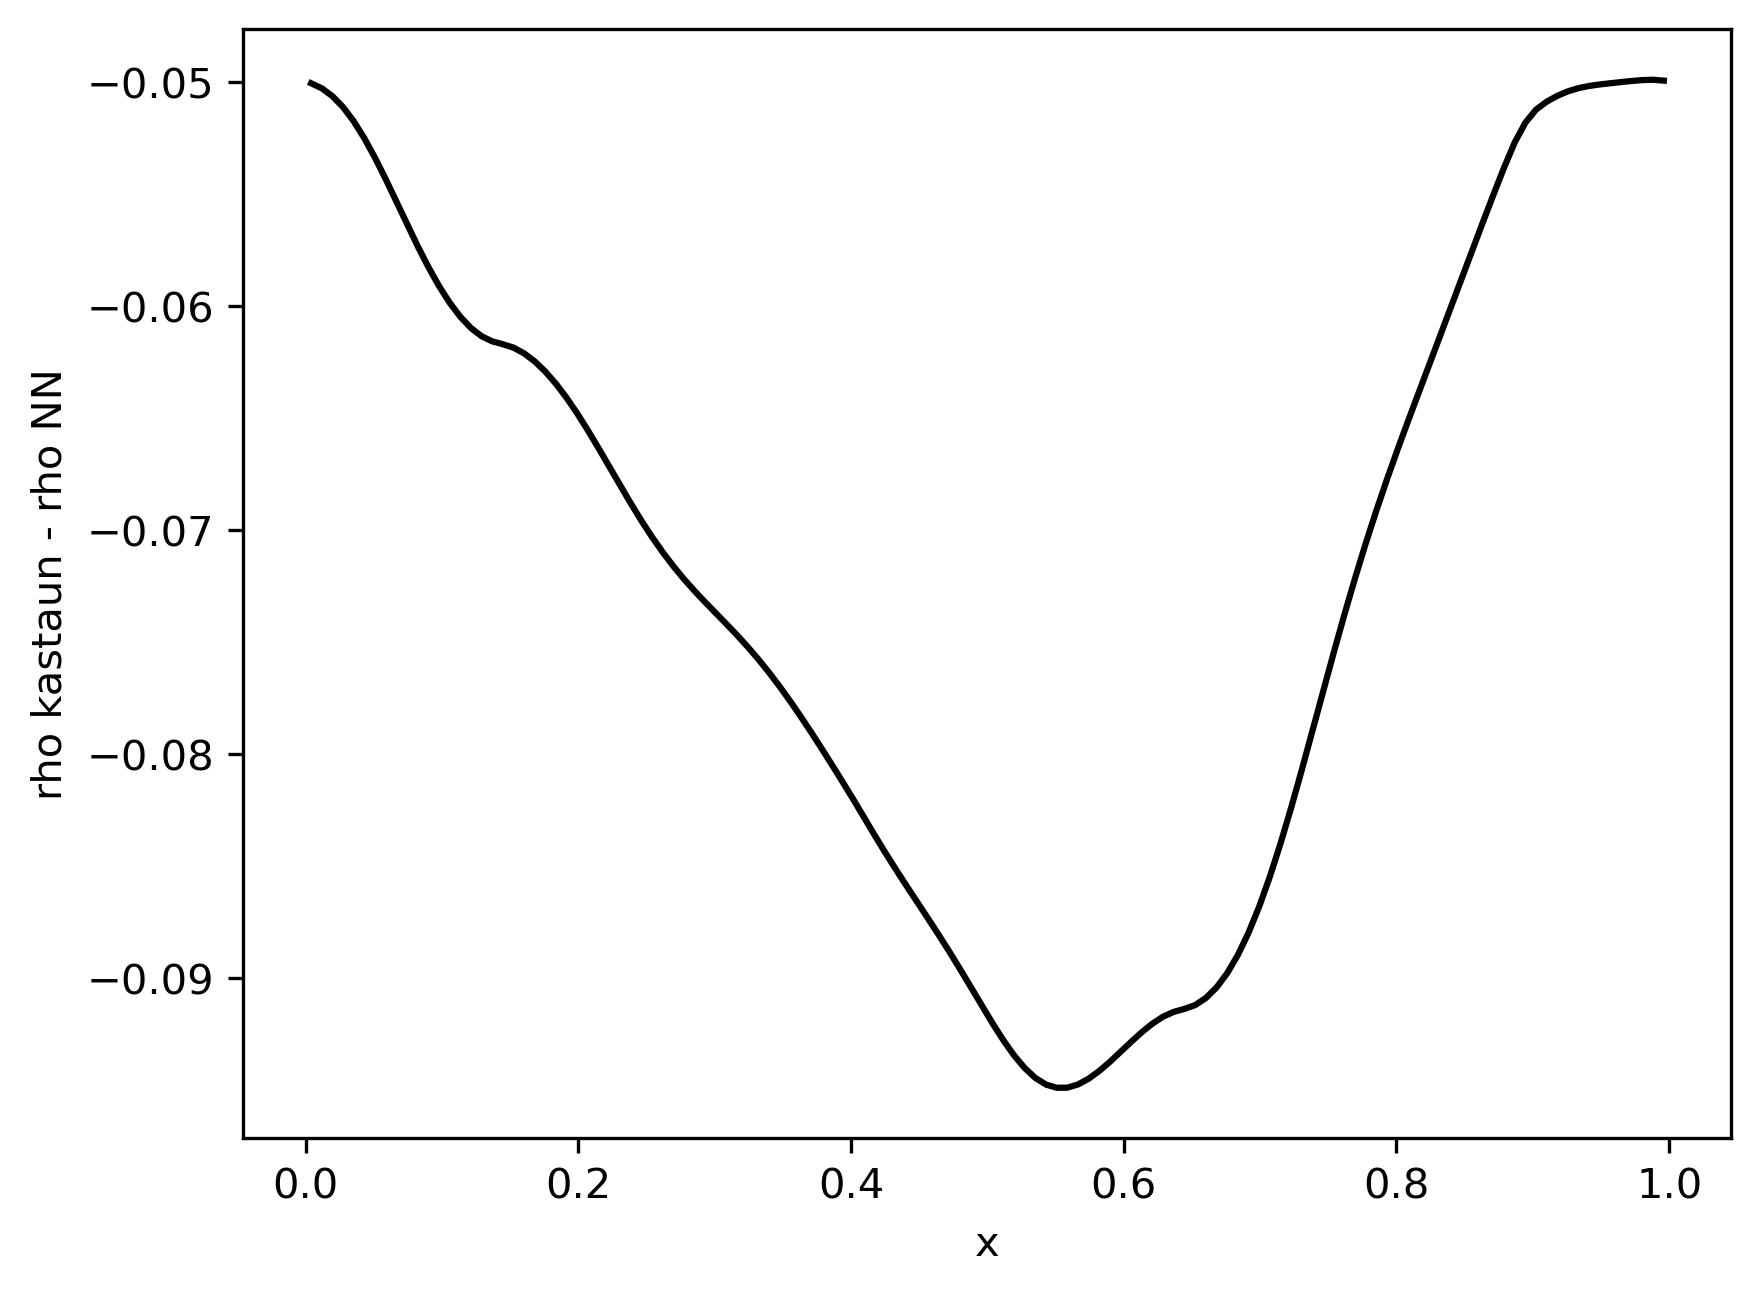

In [41]:
plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata_kastaun['rho'][srt]) - np.array(plotdata_neuralnet['rho'][srt]), '-', color='black')
plt.xlabel("x")
plt.ylabel("rho kastaun - rho NN")
plt.show()

## Only Kastaun wave

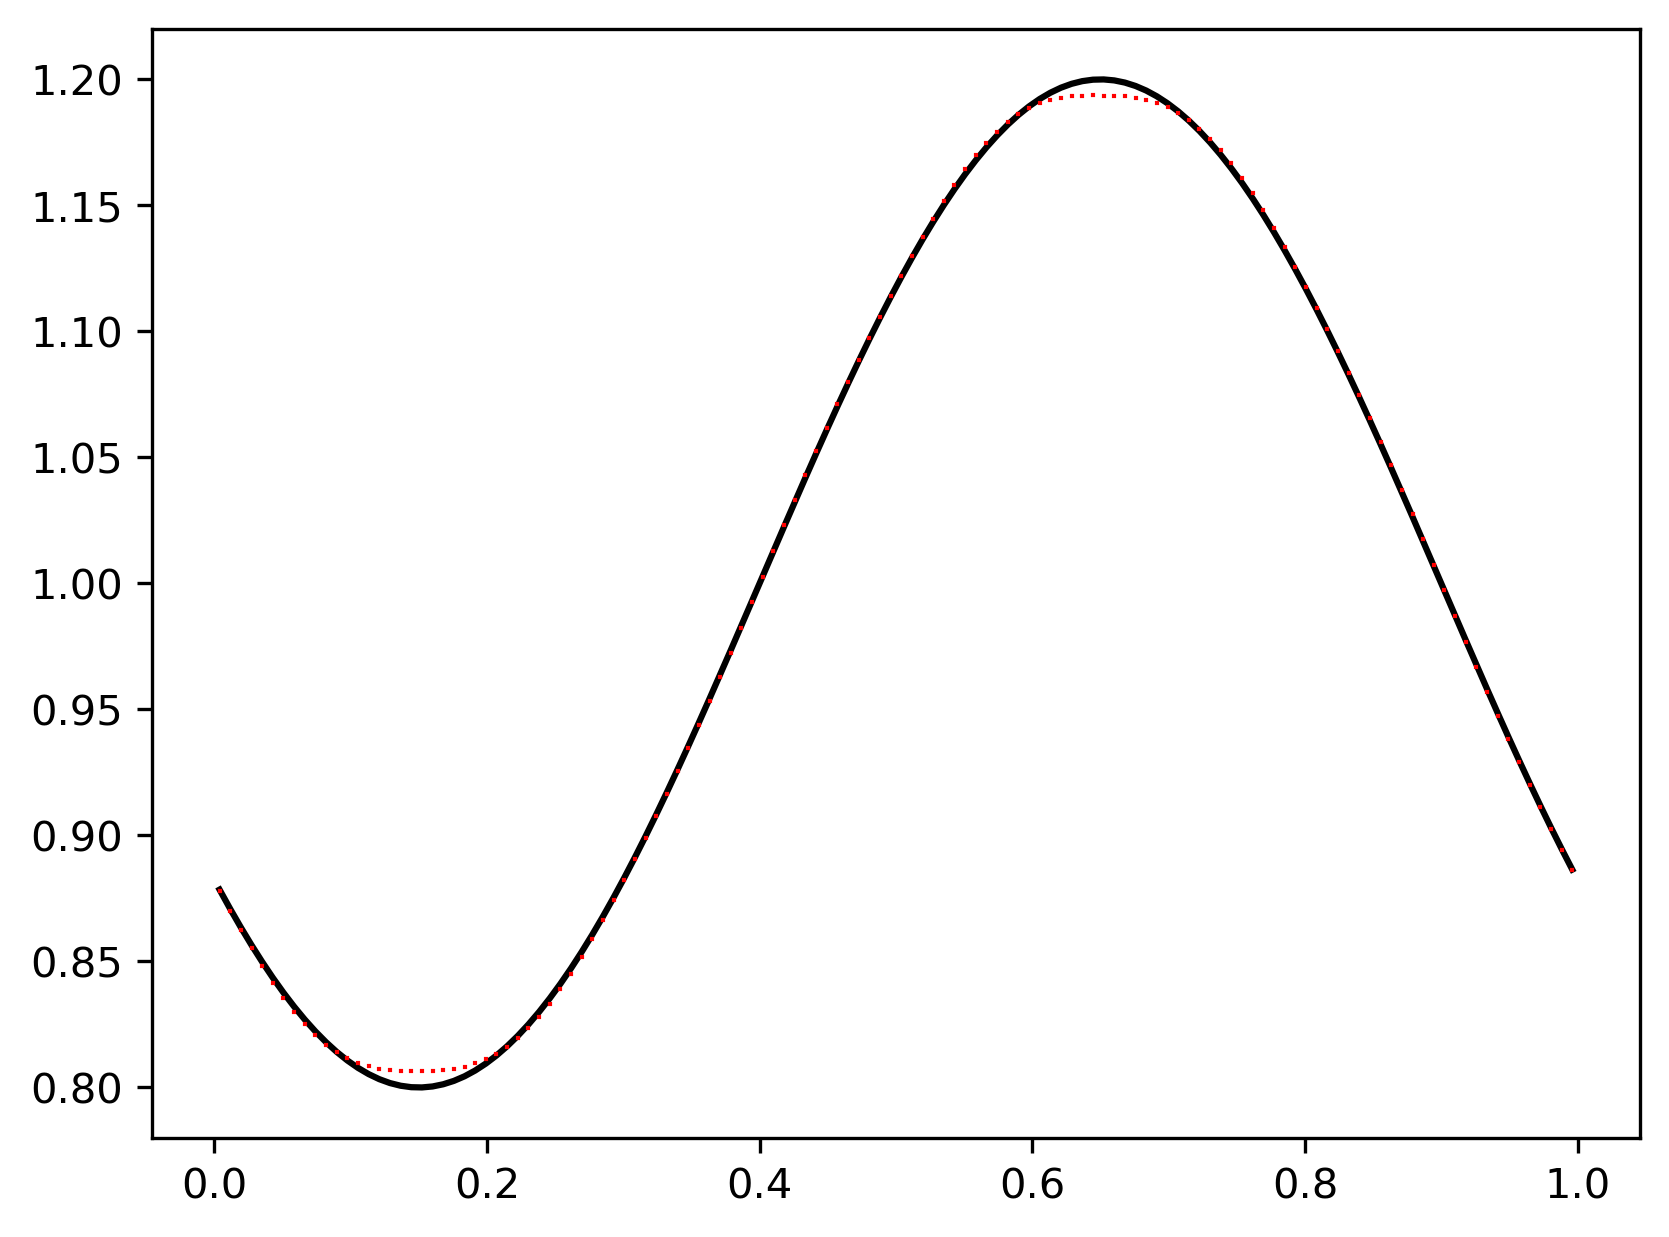

In [30]:
waves = [kastaun_wave]
labels = ["Kastaun"]
for i, wave in enumerate(waves):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]),0.0,T_final))
    
    plt.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact")
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), 'r+', ms = 1, label=labels[i])
    plt.show()


## Only neural net wave

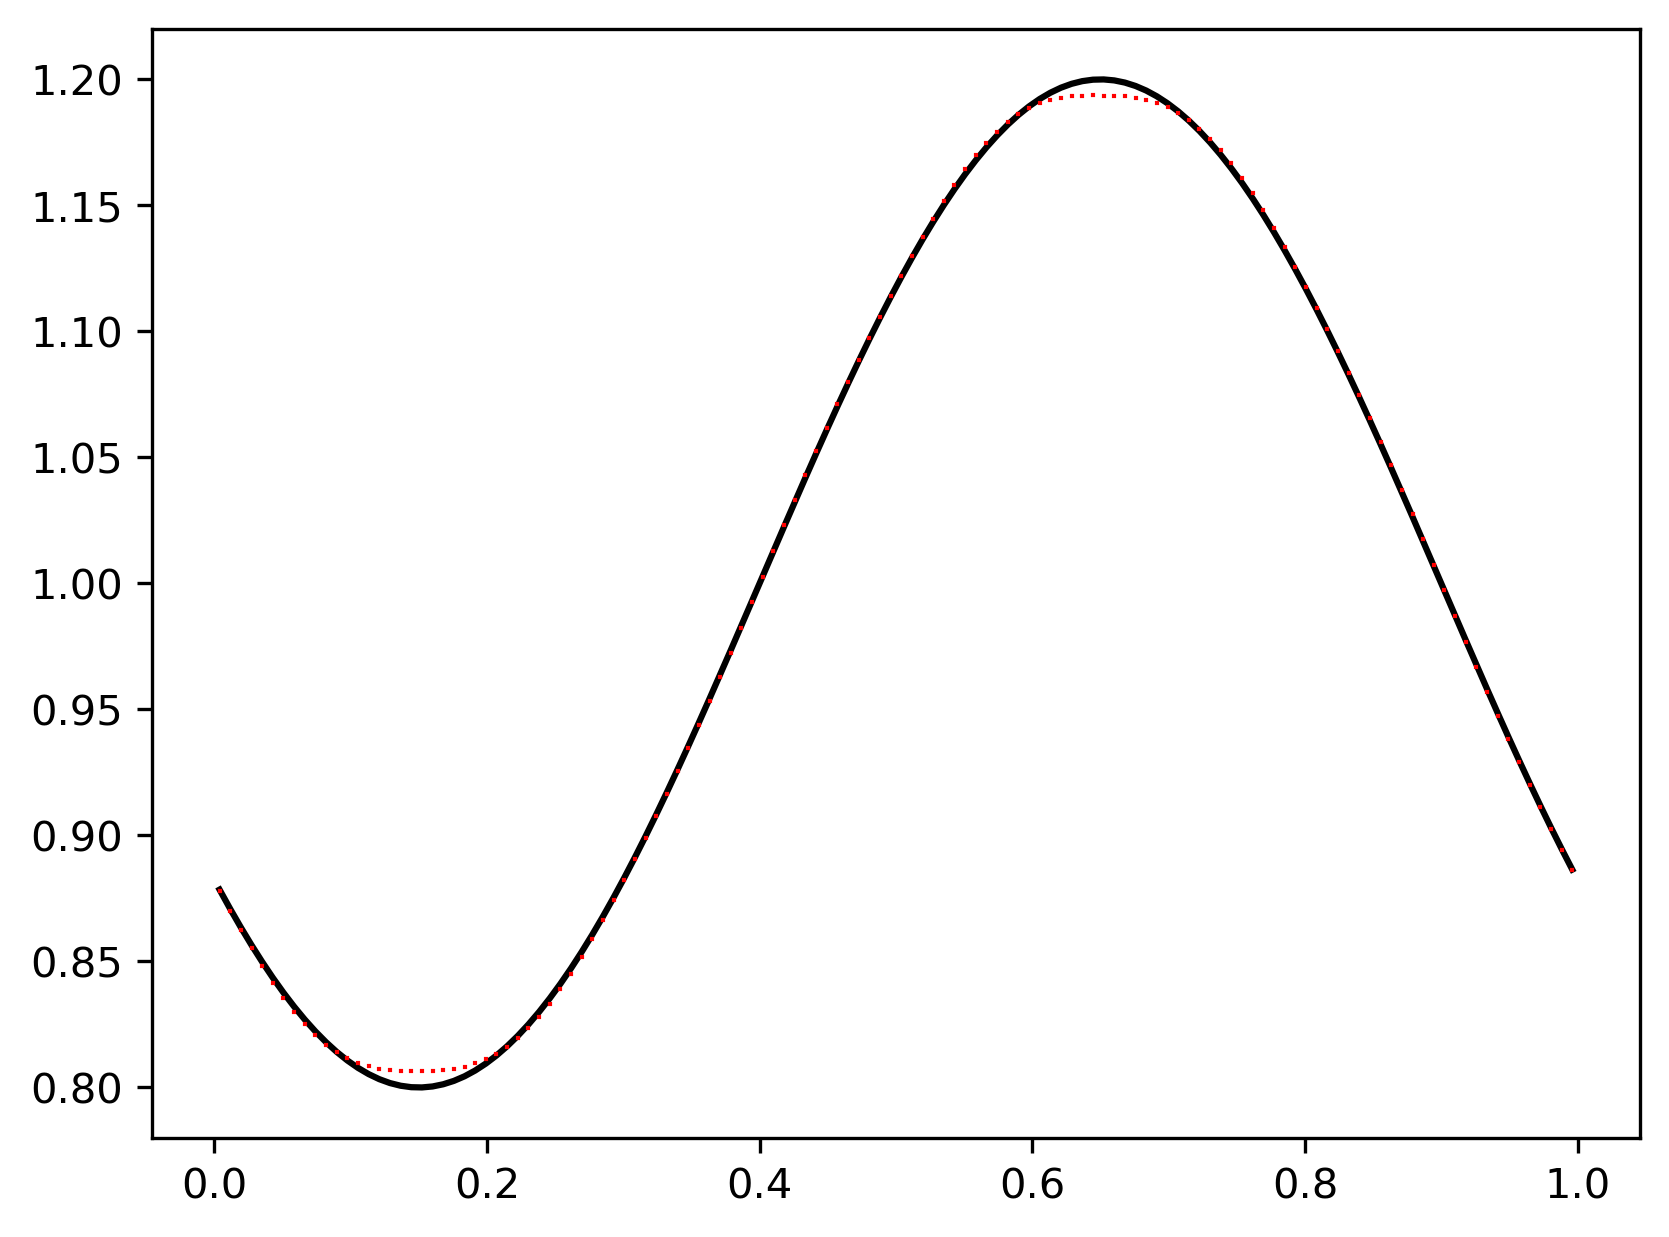

In [29]:
waves = [neuralnet_wave]
labels = ["Neural net"]
for i, wave in enumerate(waves):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]),0.0,T_final))
    
    plt.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact")
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), 'r+', ms = 1, label=labels[i])
    plt.show()
